In [3]:
%matplotlib inline
import numpy as np
from lmfit import Parameters, Minimizer
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from ctisim.fitting import SimpleModel, SimulatedModel
from ctisim import ITL_AMP_GEOM
from ctisim.utils import OverscanParameterResults

# Testing LMFit Usage

In [50]:
infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdulist = fits.open(infile)
max_signal = 150000.
error = 7.2/np.sqrt(2000.)

amp = 7
start = 3
stop = 13
num_transfers = 512

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

params = Parameters()
params.add('ctiexp', value=-6, min=-7, max=-5, vary=False)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.4, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=0.0005, min=0., max=0.01)
params.add('decaytime', value=1.6, min=0.01, max=10.0)
params.add('threshold', value=100.0, min=0.0, max=150000.)

model = SimpleModel()

minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                   fcn_kws={'start' : start, 'stop' : stop})
result = minner.minimize()

print(result.params)

Parameters([('ctiexp', <Parameter 'ctiexp', value=-6 (fixed), bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.4 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.0002216224135500794 +/- 4.16e-06, bounds=[0.0:0.01]>), ('decaytime', <Parameter 'decaytime', value=2.482886682802655 +/- 0.0285, bounds=[0.01:10.0]>), ('threshold', <Parameter 'threshold', value=6.00299476793964e-05 +/- 460, bounds=[0.0:150000.0]>)])


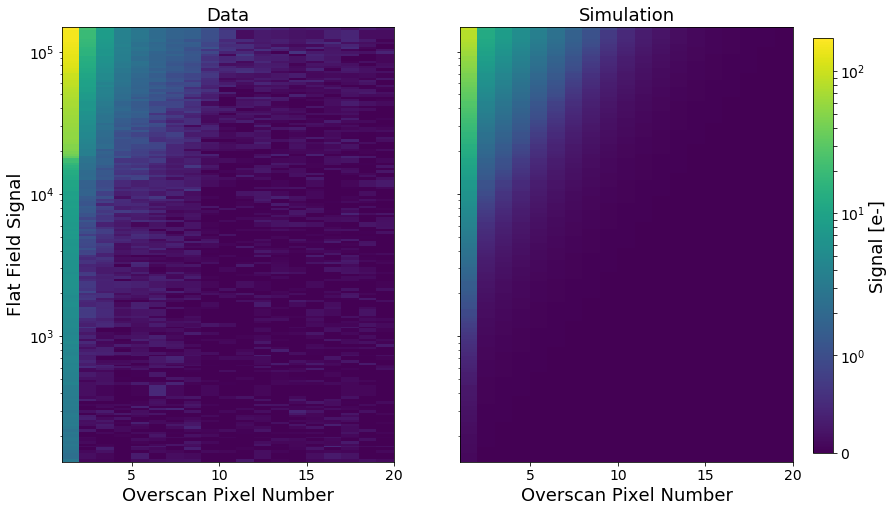

In [51]:
start = 1
stop = 20
num_transfers = 512

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

res = SimpleModel.model_results(result.params,signals, num_transfers, start=start, stop=stop)

## Setting up PColor plot
vmin = 0.0
vmax = np.max(data)
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, data, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, res, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Data', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Simulation', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

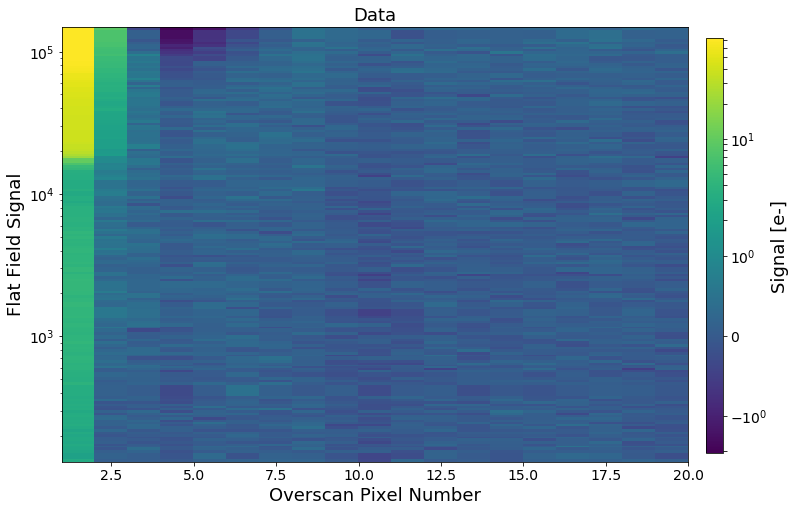

In [52]:
## Setting up PColor plot
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
im0 = ax.pcolor(X, Y, data-res, 
                     norm=SymLogNorm(1.0))
ax.set_yscale('log')
ax.set_ylabel('Flat Field Signal', fontsize=18)
ax.set_xlabel('Overscan Pixel Number', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Data', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

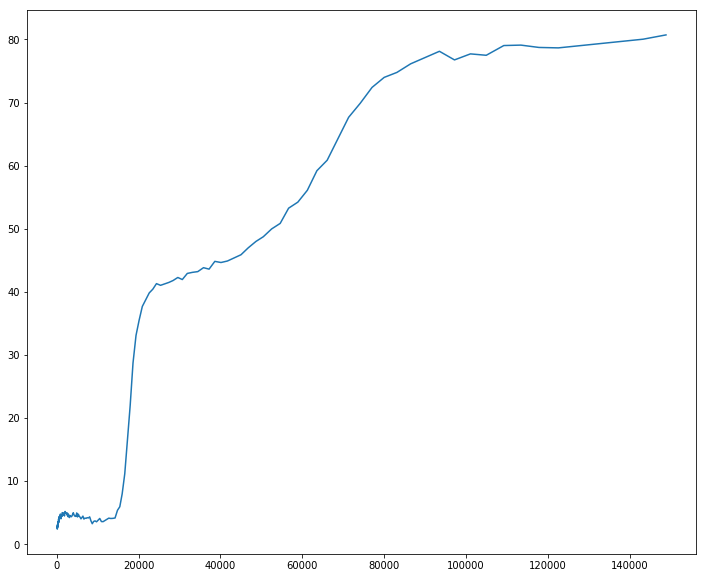

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(signals, np.sum((data-res)[:, :2], axis=1))

## Best Way to Fit Electronics

In [37]:
infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdulist = fits.open(infile)
max_signal = 10000.
error = 7.2/np.sqrt(2000.)

start = 1
stop = 2
num_transfers = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width

amp = 1

## Electronics fit
param_results = OverscanParameterResults.from_fits('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_parameter_results.fits')

for amp in range(1, 17):
    print(amp)

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    params = Parameters()
    params.add('ctiexp', value=-6, min=-7, max=-5, vary=True)
    params.add('trapsize', value=0.0, min=0., max=10., vary=True)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=True)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)

    model = SimpleModel()

    minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                           fcn_kws={'start' : start, 'stop' : stop})
    result = minner.minimize()
   
    if result.params['trapsize'] < 1.0:
        print("No trap")
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=-5, vary=True)
        params.add('trapsize', value=0.0, min=0., max=10., vary=False)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
        params.add('emissiontime', value=0.4, min=0.1, max=1.0, vary=False)
        params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
        params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)

        model = SimpleModel()

        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                               fcn_kws={'start' : start, 'stop' : stop})
        result = minner.minimize()
        print(result.params)
    else:
        print("Trap")
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=-5, vary=True)
        params.add('trapsize', value=3.0, min=0., max=10., vary=True)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=True)
        params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=True)
        params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
        params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)

        model = SimpleModel()

        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                               fcn_kws={'start' : start, 'stop' : stop})
        result = minner.minimize()
        print(result.params)
        
        

1
No trap
Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.307818132682753 +/- 0.00904, bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.4 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.00021237427 (fixed), bounds=[0.0:0.001]>), ('decaytime', <Parameter 'decaytime', value=2.5051641 (fixed), bounds=[0.1:4.0]>), ('threshold', <Parameter 'threshold', value=5.0782506e-05 (fixed), bounds=[0.0:150000.0]>)])
2
No trap
Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.226879668641337 +/- 0.00742, bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.4 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.000

Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.250506118446033 +/- 0.00764, bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.4 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.00021589905 (fixed), bounds=[0.0:0.001]>), ('decaytime', <Parameter 'decaytime', value=2.4076402 (fixed), bounds=[0.1:4.0]>), ('threshold', <Parameter 'threshold', value=2.4258373e-08 (fixed), bounds=[0.0:150000.0]>)])
16
No trap
Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.269031793018461 +/- 0.011, bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.4 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.00019646768 (f